In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import random
import numpy as np
import cv2
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torchvision import transforms as T
from torchvision.transforms import ToTensor
from torchvision.transforms import functional as F

from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import MobileNet_V3_Large_Weights

from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from pycocotools.cocoeval import COCOeval


## Segmentation Creation

In [ ]:
def convert_bbox_to_segmentation(bbox):
    """Convert [x, y, w, h] to polygon: [x, y, x+w, y, x+w, y+h, x, y+h]"""
    x, y, w, h = bbox
    return [[
        x, y,
        x + w, y,
        x + w, y + h,
        x, y + h
    ]]

def add_segmentation_to_coco(coco_path, output_path):
    with open(coco_path, 'r') as f:
        coco = json.load(f)

    missing = 0
    for ann in coco['annotations']:
        if 'segmentation' not in ann or not ann['segmentation']:
            ann['segmentation'] = convert_bbox_to_segmentation(ann['bbox'])
            missing += 1

    print(f"✅ Added segmentation to {missing} annotations")

    with open(output_path, 'w') as f:
        json.dump(coco, f)
    print(f"📁 Saved new COCO file with segmentation: {output_path}")

input_train_json = '/kaggle/input/coco-format/train_coco.json'
input_val_json = '/kaggle/input/coco-format/val_coco.json'

output_train_json = '/kaggle/working/train_coco_with_seg.json'
output_val_json = '/kaggle/working/val_coco_with_seg.json'

add_segmentation_to_coco(input_train_json, output_train_json)
add_segmentation_to_coco(input_val_json, output_val_json)


✅ Added segmentation to 5615 annotations
📁 Saved new COCO file with segmentation: /kaggle/working/train_coco_with_seg.json
✅ Added segmentation to 937 annotations
📁 Saved new COCO file with segmentation: /kaggle/working/val_coco_with_seg.json


## Dataset Creation

In [ ]:

class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, masks = [], [], []

        for ann in anns:
            if 'segmentation' in ann:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(1)  

                rle = coco_mask.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask = coco_mask.decode(rle)
                if len(mask.shape) == 3:  
                    mask = np.any(mask, axis=2).astype(np.uint8)
                masks.append(torch.as_tensor(mask, dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks) if masks else torch.zeros((0, img.height, img.width), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


def get_transform(train):
    return torchvision.transforms.Compose([ToTensor()])



## Model 

In [ ]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import MobileNet_V3_Large_Weights


backbone = mobilenet_backbone(
    'mobilenet_v3_large',
    weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
    fpn=True
)

anchor_generator = AnchorGenerator(
    sizes=((32,), (64,), (128,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 3
)

model = MaskRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)


## Loading Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format-seg/train_coco_with_seg.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format-seg/val_coco_with_seg.json",
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Training

In [ ]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    batch_losses = []
    mask_loss_total = 0.0  

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        mask_loss_total += loss_dict['loss_mask'].item()

        batch_losses.append(losses.item())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_mask_loss = mask_loss_total / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f} | Avg Mask Loss: {avg_mask_loss:.4f}")
    lr_scheduler.step()



Epoch [1/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [1/50] - Avg Loss: 0.5679 | Avg Mask Loss: 0.2750

Epoch [2/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [2/50] - Avg Loss: 0.5998 | Avg Mask Loss: 0.2644

Epoch [3/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [3/50] - Avg Loss: 0.5781 | Avg Mask Loss: 0.2439

Epoch [4/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [4/50] - Avg Loss: 0.5529 | Avg Mask Loss: 0.2343

Epoch [5/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [5/50] - Avg Loss: 0.5262 | Avg Mask Loss: 0.2230

Epoch [6/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [6/50] - Avg Loss: 0.5031 | Avg Mask Loss: 0.2154

Epoch [7/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [7/50] - Avg Loss: 0.4833 | Avg Mask Loss: 0.2071

Epoch [8/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [8/50] - Avg Loss: 0.4563 | Avg Mask Loss: 0.1998

Epoch [9/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [9/50] - Avg Loss: 0.4394 | Avg Mask Loss: 0.1952

Epoch [10/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [10/50] - Avg Loss: 0.4239 | Avg Mask Loss: 0.1892

Epoch [11/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [11/50] - Avg Loss: 0.4009 | Avg Mask Loss: 0.1808

Epoch [12/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [12/50] - Avg Loss: 0.3901 | Avg Mask Loss: 0.1755

Epoch [13/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [13/50] - Avg Loss: 0.3851 | Avg Mask Loss: 0.1742

Epoch [14/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [14/50] - Avg Loss: 0.3662 | Avg Mask Loss: 0.1668

Epoch [15/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [15/50] - Avg Loss: 0.3471 | Avg Mask Loss: 0.1612

Epoch [16/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [16/50] - Avg Loss: 0.3029 | Avg Mask Loss: 0.1480

Epoch [17/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [17/50] - Avg Loss: 0.2913 | Avg Mask Loss: 0.1426

Epoch [18/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [18/50] - Avg Loss: 0.2834 | Avg Mask Loss: 0.1384

Epoch [19/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [19/50] - Avg Loss: 0.2821 | Avg Mask Loss: 0.1387

Epoch [20/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [20/50] - Avg Loss: 0.2792 | Avg Mask Loss: 0.1375

Epoch [21/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [21/50] - Avg Loss: 0.2753 | Avg Mask Loss: 0.1362

Epoch [22/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [22/50] - Avg Loss: 0.2718 | Avg Mask Loss: 0.1346

Epoch [23/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [23/50] - Avg Loss: 0.2708 | Avg Mask Loss: 0.1343

Epoch [24/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [24/50] - Avg Loss: 0.2697 | Avg Mask Loss: 0.1348

Epoch [25/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [25/50] - Avg Loss: 0.2668 | Avg Mask Loss: 0.1339

Epoch [26/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [26/50] - Avg Loss: 0.2630 | Avg Mask Loss: 0.1310

Epoch [27/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [27/50] - Avg Loss: 0.2627 | Avg Mask Loss: 0.1315

Epoch [28/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [28/50] - Avg Loss: 0.2608 | Avg Mask Loss: 0.1311

Epoch [29/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [29/50] - Avg Loss: 0.2591 | Avg Mask Loss: 0.1299

Epoch [30/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [30/50] - Avg Loss: 0.2568 | Avg Mask Loss: 0.1298

Epoch [31/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [31/50] - Avg Loss: 0.2515 | Avg Mask Loss: 0.1279

Epoch [32/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [32/50] - Avg Loss: 0.2504 | Avg Mask Loss: 0.1272

Epoch [33/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [33/50] - Avg Loss: 0.2513 | Avg Mask Loss: 0.1275

Epoch [34/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [34/50] - Avg Loss: 0.2509 | Avg Mask Loss: 0.1281

Epoch [35/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [35/50] - Avg Loss: 0.2506 | Avg Mask Loss: 0.1272

Epoch [36/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [36/50] - Avg Loss: 0.2503 | Avg Mask Loss: 0.1274

Epoch [37/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [37/50] - Avg Loss: 0.2487 | Avg Mask Loss: 0.1263

Epoch [38/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [38/50] - Avg Loss: 0.2493 | Avg Mask Loss: 0.1262

Epoch [39/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [39/50] - Avg Loss: 0.2510 | Avg Mask Loss: 0.1278

Epoch [40/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [40/50] - Avg Loss: 0.2484 | Avg Mask Loss: 0.1267

Epoch [41/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [41/50] - Avg Loss: 0.2497 | Avg Mask Loss: 0.1268

Epoch [42/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [42/50] - Avg Loss: 0.2487 | Avg Mask Loss: 0.1264

Epoch [43/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [43/50] - Avg Loss: 0.2497 | Avg Mask Loss: 0.1275

Epoch [44/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [44/50] - Avg Loss: 0.2497 | Avg Mask Loss: 0.1271

Epoch [45/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [45/50] - Avg Loss: 0.2468 | Avg Mask Loss: 0.1254

Epoch [46/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [46/50] - Avg Loss: 0.2468 | Avg Mask Loss: 0.1258

Epoch [47/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [47/50] - Avg Loss: 0.2475 | Avg Mask Loss: 0.1259

Epoch [48/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [48/50] - Avg Loss: 0.2481 | Avg Mask Loss: 0.1270

Epoch [49/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [49/50] - Avg Loss: 0.2483 | Avg Mask Loss: 0.1266

Epoch [50/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [50/50] - Avg Loss: 0.2474 | Avg Mask Loss: 0.1264


In [ ]:
torch.save(model.state_dict(), "mrcnnmobnetmask_vehicle_detector.pth") # Save Model


## Evaluation

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 22.1MB/s]


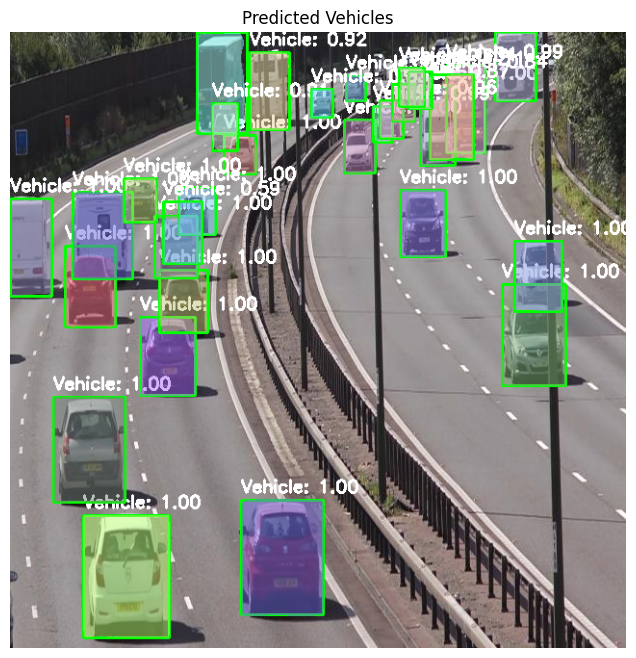

In [ ]:
def get_model(num_classes=2):
    backbone = mobilenet_backbone("mobilenet_v3_large", fpn=True, weights="DEFAULT")
    
    anchor_sizes = ((32,), (64,), (128,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    model = MaskRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=rpn_anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()
model.load_state_dict(torch.load("/kaggle/working/mrcnnmobnetmask_vehicle_detector.pth", map_location=device))
model.to(device)
model.eval()

transform = T.Compose([T.ToTensor()])

def predict_and_plot(img_path, threshold=0.5):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    img_np = np.array(img).copy()

    for i, score in enumerate(output["scores"]):
        if score < threshold:
            continue

        box = output["boxes"][i].cpu().numpy().astype(int)
        mask = output["masks"][i, 0].cpu().numpy()

        cv2.rectangle(img_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        label = f"Vehicle: {score:.2f}"
        cv2.putText(img_np, label, (box[0], box[1] - 8), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2)

        binary_mask = (mask > 0.5).astype(np.uint8)
        color = [random.randint(100, 255) for _ in range(3)]
        for c in range(3):
            img_np[:, :, c] = np.where(binary_mask == 1,
                                       img_np[:, :, c] * 0.5 + color[c] * 0.5,
                                       img_np[:, :, c])

    plt.figure(figsize=(10, 8))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Predicted Vehicles")
    plt.show()

predict_and_plot("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg")


## Metrics

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/working/mrcnnmobnetmask_vehicle_detector.pth" 
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format-seg/val_coco_with_seg.json"
CONF_THRESH = 0.5

def get_model():
    backbone = mobilenet_backbone('mobilenet_v3_large',
                                  weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                                  fpn=True)

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(backbone,
                     num_classes=2,
                     rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


model = get_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

coco_gt = COCO(ANN_PATH)
img_ids = coco_gt.getImgIds()
cat_ids = coco_gt.getCatIds()
CAT_ID = cat_ids[0] 

to_tensor = T.ToTensor()
preds = []

for img_id in tqdm(img_ids, desc="Running inference"):
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id": img_id,
            "category_id": CAT_ID,
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score": float(score)
        })


with open("predictions.json", "w") as f:
    json.dump(preds, f)

coco_dt = coco_gt.loadRes("predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Running inference: 100%|██████████| 90/90 [00:04<00:00, 21.57it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

## Testing on dataset

🚌 Detected 32 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


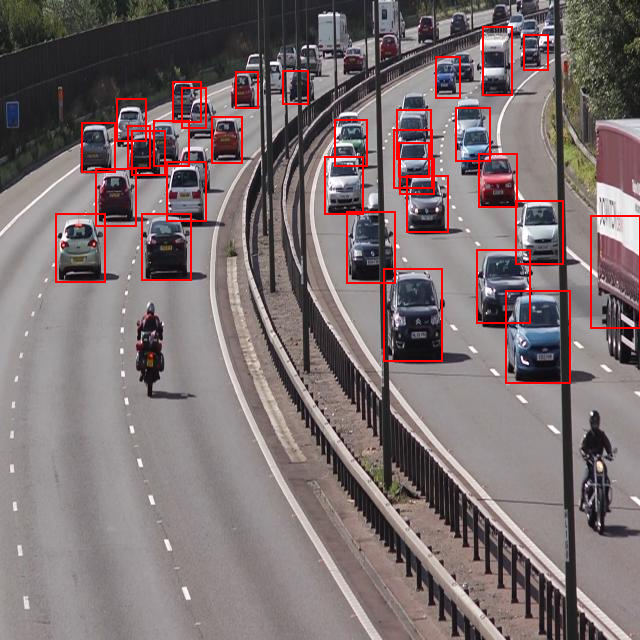

🚌 Detected 20 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


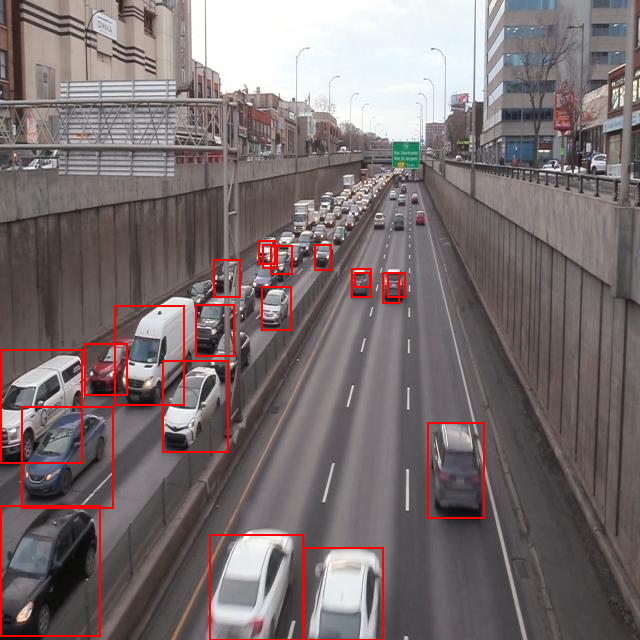

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


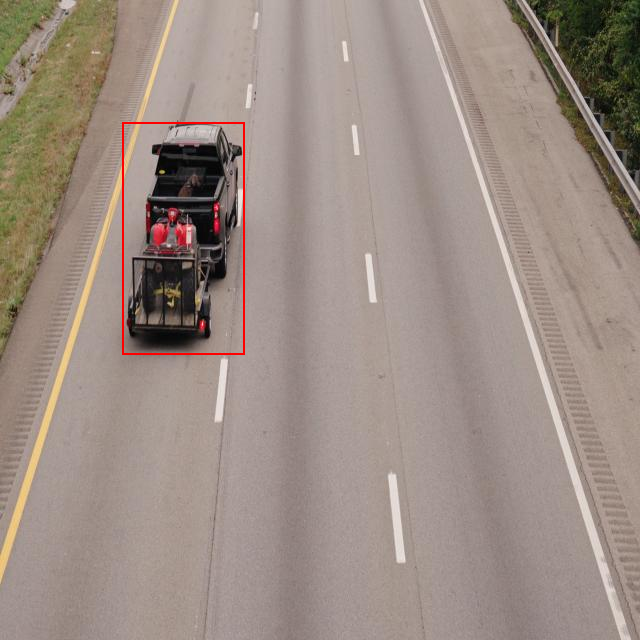

In [ ]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.transforms.functional import to_tensor
from PIL import Image, ImageDraw
import torch, os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_custom_model():
   
    backbone = mobilenet_backbone(
        'mobilenet_v3_large',
        weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
        fpn=True
    )

   
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),                      
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(
        backbone,
        num_classes=2,  
        rpn_anchor_generator=anchor_generator
    )

 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

   
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model

model = get_custom_model()
model.load_state_dict(torch.load("/kaggle/working/mrcnnmobnetmask_vehicle_detector.pth", map_location=device))
model.to(device)
model.eval()

def count_vehicles(image_path, score_thresh=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > score_thresh for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")


    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > score_thresh:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    display(image)


val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[21:24]:  
    count_vehicles(os.path.join(val_image_dir, fname))


## Video Testing

In [17]:
!pip install deep_sort_realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 58.7 MB/s eta 0:00:0000:0100:01


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms as T
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import MobileNet_V3_Large_Weights
from deep_sort_realtime.deepsort_tracker import DeepSort

VIDEO_PATH = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
MODEL_PATH = "/kaggle/working/mrcnnmobnetmask_vehicle_detector.pth"
OUTPUT_PATH = "tracked_output_livecount.mp4"
CONF_THRESH = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_custom_model():
    backbone = mobilenet_backbone('mobilenet_v3_large',
                                  weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                                  fpn=True)

  
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


model = get_custom_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

cap = cv2.VideoCapture(VIDEO_PATH)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))

transform = T.ToTensor()
tracker = DeepSort(max_age=30)
PIXELS_PER_METER = 10
ROI_LINE_Y = int(0.6 * H)

entry_count = 0
exit_count = 0
object_last_centers = {}

# Main Loop 
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    detections = []
    for box, score in zip(output["boxes"], output["scores"]):
        if score >= CONF_THRESH:
            x1, y1, x2, y2 = box.int().tolist()
            w, h = x2 - x1, y2 - y1
            detections.append(([x1, y1, w, h], float(score), "vehicle"))

    tracks = tracker.update_tracks(detections, frame=frame)
    visible_vehicle_count = 0

    for track in tracks:
        if not track.is_confirmed():
            continue
        visible_vehicle_count += 1

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if track_id in object_last_centers:
            prev_cx, prev_cy = object_last_centers[track_id]
            if prev_cy < ROI_LINE_Y <= cy:
                entry_count += 1
            elif prev_cy > ROI_LINE_Y >= cy:
                exit_count += 1

            dist_px = np.hypot(cx - prev_cx, cy - prev_cy)
            speed = (dist_px * FPS) / PIXELS_PER_METER
        else:
            speed = 0

        object_last_centers[track_id] = (cx, cy)

        # Draw box & speed
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f"ID:{track_id} S:{speed:.1f}m/s", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Overlay info
    cv2.line(frame, (0, ROI_LINE_Y), (W, ROI_LINE_Y), (255, 255, 0), 2)
    cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"Vehicles in Frame: {visible_vehicle_count}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out_vid.write(frame)

cap.release()
out_vid.release()
print("✅ Saved: Tracked video with Live Vehicle Count")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


✅ Saved: Tracked video with Live Vehicle Count


## Thank You!